In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os

# 1. 설정
# 1. 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "../models/koelectra_finetuned/koelectra_model.pt"

# 🚨 수정된 부분: 경로 앞에 '../' 추가
DATA_PATH = "../data/02_processed/reviews_cleaned.csv"
SAVE_PATH = "../data/03_final/final_result.csv"

# 2. 모델 및 토크나이저 로드
print("모델 로딩 중...")
MODEL_NAME = "monologg/koelectra-base-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5, weights_only=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval() # 평가 모드

# 3. 전체 데이터 로드
df = pd.read_csv(DATA_PATH)
print(f"전체 분석 대상: {len(df)}건")

# 4. 데이터셋 정의 (라벨 없이 텍스트만)
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# 데이터셋 & 로더 생성
inference_dataset = InferenceDataset(df['cleaned_review'].tolist(), tokenizer)
inference_loader = DataLoader(inference_dataset, batch_size=64, shuffle=False) # 배치 사이즈 키워도 됨

# 5. 예측 실행 (Inference)
print("전체 데이터 분석 시작...")
all_predictions = []

with torch.no_grad():
    for batch in tqdm(inference_loader, desc="Analyzing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # 가장 높은 확률을 가진 라벨 선택
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(preds)

# 6. 결과 저장
df['predicted_label'] = all_predictions

# 라벨 이름 매핑 (보기 좋게)
label_map = {
    0: '보습/수분',
    1: '진정/트러블',
    2: '사용감/흡수',
    3: '자극/부작용',
    4: '기타'
}
df['category'] = df['predicted_label'].map(label_map)

# 저장
df.to_csv(SAVE_PATH, index=False, encoding='utf-8-sig')
print(f"🎉 분석 완료! 결과 저장됨: {SAVE_PATH}")

# 7. 결과 요약 출력
print("\n[분석 결과 요약]")
print(df['category'].value_counts())

모델 로딩 중...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_1020\3333927146.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to

전체 분석 대상: 92559건
전체 데이터 분석 시작...


Analyzing:   0%|          | 0/1447 [00:00<?, ?it/s]

🎉 분석 완료! 결과 저장됨: ../data/03_final/final_result.csv

[분석 결과 요약]
category
보습/수분     40524
진정/트러블    27326
기타        16887
사용감/흡수     7822
Name: count, dtype: int64


✅ 한글 폰트 설정 완료!
✅ 그래프 저장 완료: results/confusion_matrix.png


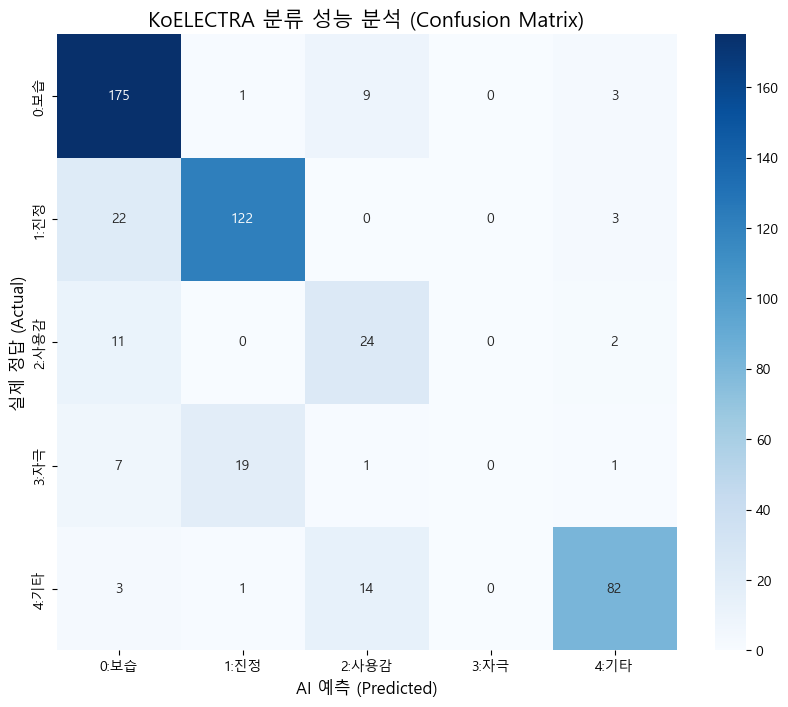

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import platform
from matplotlib import font_manager, rc

# 1. 한글 폰트 강제 설정 (깨짐 해결)
def set_korean_font():
    system_name = platform.system()
    if system_name == 'Windows':
        # 윈도우: 맑은 고딕 (Malgun Gothic)
        font_path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=font_path).get_name()
        rc('font', family=font_name)
    elif system_name == 'Darwin':
        # 맥(Mac): 애플 고딕 (AppleGothic)
        rc('font', family='AppleGothic')
    else:
        # 리눅스/코랩: 나눔고딕 (설치 필요할 수 있음)
        print("⚠️ 리눅스/코랩 환경입니다. 한글 폰트가 없다면 깨질 수 있습니다.")

    # 마이너스(-) 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()
print("✅ 한글 폰트 설정 완료!")

# 2. 혼동 행렬 다시 그리기
target_names = ['0:보습', '1:진정', '2:사용감', '3:자극', '4:기타']
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
# annot=True: 숫자 표시, fmt='d': 정수 형태, cmap='Blues': 파란색 테마
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)

plt.ylabel('실제 정답 (Actual)', fontsize=12)
plt.xlabel('AI 예측 (Predicted)', fontsize=12)
plt.title('KoELECTRA 분류 성능 분석 (Confusion Matrix)', fontsize=15)

# 이미지 저장
plt.savefig("results/confusion_matrix.png", dpi=300)
print("✅ 그래프 저장 완료: results/confusion_matrix.png")

plt.show()

🔥 사용 장치: cuda
📂 데이터 경로: ../data/03_final/train_data_fixed.csv
모델 로딩 중...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_1020\3150771449.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to

📊 정밀 평가 시작...


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 13.22it/s]
C:\Users\user\PycharmProjects\Cosmetics_Project\.venv1\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\PycharmProjects\Cosmetics_Project\.venv1\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\PycharmProjects\Cosmetics_Project\.venv1\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d


[논문급 상세 분석 리포트]
              precision    recall  f1-score   support

        0:보습       0.80      0.93      0.86       188
        1:진정       0.85      0.83      0.84       147
       2:사용감       0.50      0.65      0.56        37
        3:자극       0.00      0.00      0.00        28
        4:기타       0.90      0.82      0.86       100

    accuracy                           0.81       500
   macro avg       0.61      0.65      0.63       500
weighted avg       0.77      0.81      0.79       500

✅ 혼동 행렬 이미지 저장 완료: results/confusion_matrix.png


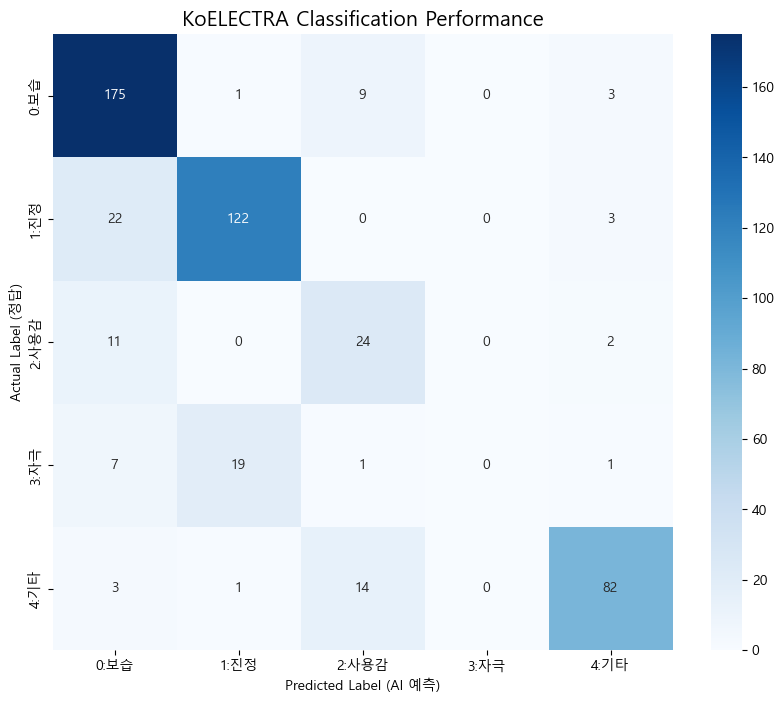

In [12]:
# 11/25 보고서용 만드는중
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# 1. 설정 및 장치 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "monologg/koelectra-base-v3-discriminator"

# 경로 설정 (본인 환경에 맞게 수정)
MODEL_PATH = "models/koelectra_finetuned/koelectra_model.pt"
DATA_PATH = "data/03_final/train_data_fixed.csv" # 라벨링된 데이터

# 경로 보정 (notebooks 폴더에 있는 경우)
if not os.path.exists(DATA_PATH):
    DATA_PATH = "../" + DATA_PATH
if not os.path.exists(MODEL_PATH):
    MODEL_PATH = "../" + MODEL_PATH

print(f"🔥 사용 장치: {device}")
print(f"📂 데이터 경로: {DATA_PATH}")

# 2. 데이터 로드 및 검증 데이터 복원 (학습 때와 동일하게 분리)
df = pd.read_csv(DATA_PATH)
text_col = 'cleaned_review' if 'cleaned_review' in df.columns else 'review'
df = df[[text_col, 'label']].dropna()
df['label'] = df['label'].astype(int)

# random_state=42로 고정해야 학습 때 썼던 그 검증 데이터가 나옵니다.
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df[text_col].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# 3. 데이터셋 & 로더 생성
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

val_dataset = ReviewDataset(val_texts, val_labels, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 4. 저장된 모델 불러오기
print("모델 로딩 중...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5, weights_only=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# 5. 정밀 평가 실행 (Confusion Matrix)
print("📊 정밀 평가 시작...")
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 6. 결과 시각화 및 리포트 출력
target_names = ['0:보습', '1:진정', '2:사용감', '3:자극', '4:기타']

# 상세 리포트
print("\n[논문급 상세 분석 리포트]")
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

# 혼동 행렬 히트맵 그리기 (포스터용 이미지 저장)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual Label (정답)')
plt.xlabel('Predicted Label (AI 예측)')
plt.title('KoELECTRA Classification Performance', fontsize=15)

# 폴더 없으면 생성 후 저장
os.makedirs("results", exist_ok=True)
save_path = "results/confusion_matrix.png"
plt.savefig(save_path)
print(f"✅ 혼동 행렬 이미지 저장 완료: {save_path}")
plt.show()

In [13]:
import os

# 저장하려는 경로가 없으면 만듭니다.
os.makedirs("data/03_final", exist_ok=True)
os.makedirs("results", exist_ok=True) # 결과 이미지 저장용 폴더도 생성

print("✅ 폴더 생성 완료!")

✅ 폴더 생성 완료!


정밀 평가 시작...


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 13.66it/s]


[논문급 상세 분석 리포트]



C:\Users\user\PycharmProjects\Cosmetics_Project\.venv1\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\PycharmProjects\Cosmetics_Project\.venv1\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\PycharmProjects\Cosmetics_Project\.venv1\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

,precision,recall,f1-score,support
0:보습,0.802752,0.930851,0.862069,188.000
1:진정,0.853147,0.829932,0.841379,147.000
2:사용감,0.500000,0.648649,0.564706,37.000
3:자극,0.000000,0.000000,0.000000,28.000
4:기타,0.901099,0.820000,0.858639,100.000
accuracy,0.806000,0.806000,0.806000,0.806
macro avg,0.611400,0.645886,0.625359,500.000
weighted avg,0.769880,0.806000,0.785019,500.000


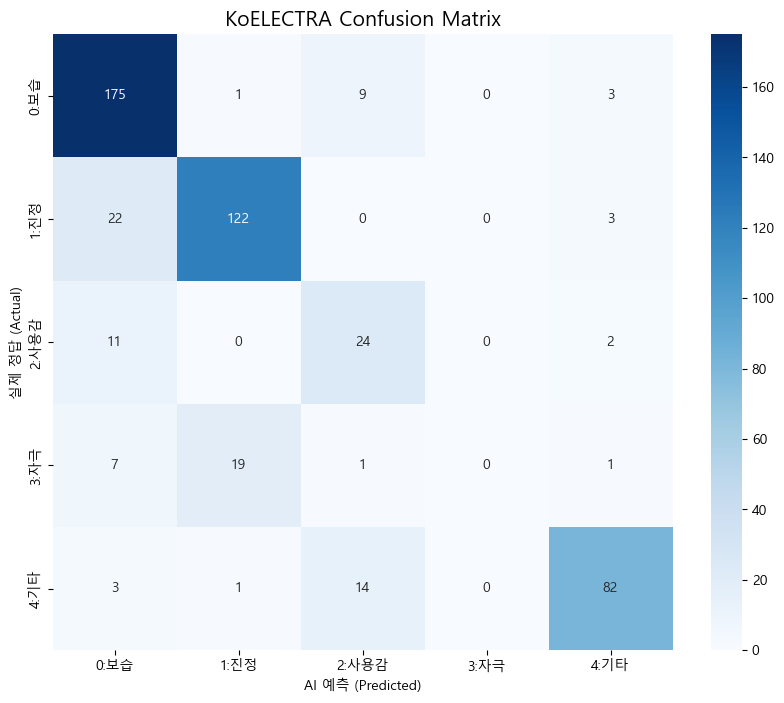

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# (학습 때 사용한 val_loader가 메모리에 있어야 합니다. 없으면 다시 로드하세요)
print("정밀 평가 시작...")

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. 상세 리포트 (Precision, Recall, F1-Score)
target_names = ['0:보습', '1:진정', '2:사용감', '3:자극', '4:기타']
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\n[논문급 상세 분석 리포트]")
display(df_report)
df_report.to_csv("data/03_final/classification_report.csv")

# 2. 혼동 행렬 (Confusion Matrix) 시각화 - 포스터 필수 그림!
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('실제 정답 (Actual)')
plt.xlabel('AI 예측 (Predicted)')
plt.title('KoELECTRA Confusion Matrix', fontsize=15)
plt.savefig("results/confusion_matrix.png") # 이미지 저장
plt.show()

In [15]:
# 틀린 데이터만 모아서 엑셀로 저장
wrong_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
wrong_reviews = [val_texts[i] for i in wrong_indices]
wrong_true_labels = [target_names[y_true[i]] for i in wrong_indices]
wrong_pred_labels = [target_names[y_pred[i]] for i in wrong_indices]

df_error = pd.DataFrame({
    'Review': wrong_reviews,
    'Actual': wrong_true_labels,
    'Predicted': wrong_pred_labels
})

df_error.to_csv("data/03_final/error_analysis.csv", index=False, encoding='utf-8-sig')
print(f"오답 노트 저장 완료: {len(df_error)}개 (data/03_final/error_analysis.csv)")

오답 노트 저장 완료: 97개 (data/03_final/error_analysis.csv)


In [17]:
import pandas as pd
import os

# 1. 전체 분석 결과 다시 불러오기
# (경로가 없으면 ../를 붙여서 찾음)
DATA_PATH = "data/03_final/final_result.csv"
if not os.path.exists(DATA_PATH):
    DATA_PATH = "../" + DATA_PATH

try:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ 데이터 로드 완료! ({len(df)}건)")
    print(f"컬럼 목록: {df.columns.tolist()}")

    # 2. 제품별 랭킹 분석 시작
    if 'product_name' in df.columns and 'category' in df.columns:
        # 제품별로 각 카테고리 리뷰가 몇 개인지 카운트
        product_stats = df.groupby(['product_name', 'category']).size().unstack(fill_value=0)

        # 리뷰 수가 너무 적은 제품(50개 미만)은 신뢰도가 낮으니 제외
        product_stats = product_stats[product_stats.sum(axis=1) > 50]

        # 비율(%)로 변환 (특정 기능에 특화된 제품 찾기 위해)
        product_ratios = product_stats.div(product_stats.sum(axis=1), axis=0)

        # 🏆 각 부문별 1등 찾기
        print("\n💧 [보습/수분] 비율이 가장 높은 제품 TOP 5")
        print(product_ratios.sort_values(by='보습/수분', ascending=False)['보습/수분'].head(5))

        print("\n🌿 [진정/트러블] 비율이 가장 높은 제품 TOP 5")
        print(product_ratios.sort_values(by='진정/트러블', ascending=False)['진정/트러블'].head(5))

        # 결과 파일 저장 (나중에 엑셀로 보고 싶을 때)
        product_ratios.to_csv("data/03_final/product_ranking.csv", encoding='utf-8-sig')
        print("\n✅ 제품별 분석 결과 저장됨: data/03_final/product_ranking.csv")

    else:
        print("❌ 오류: 'product_name' 컬럼이 없습니다. crawling.ipynb 단계에서 제품명이 제대로 저장되었는지 확인해주세요.")

except FileNotFoundError:
    print("❌ 파일을 찾을 수 없습니다. Step 4(전체 분석)를 먼저 완료해주세요.")

✅ 데이터 로드 완료! (92559건)
컬럼 목록: ['Unnamed: 0', 'product_name', 'rating', 'skin_type', 'review', 'cleaned_review', 'id', 'predicted_label', 'category']

💧 [보습/수분] 비율이 가장 높은 제품 TOP 5
product_name
닥터디퍼런트 131 모이스처라이저 100ml                         0.815217
에스테덤 셀룰러 워터 크림 50ml                              0.809524
[단독기획] 미샤 수퍼아쿠아 울트라 히알론크림 70ml                   0.805195
[단독기획] 땡큐파머 트루 워터 딥 세럼 EX (본품60ml+20ml 추가 증정)    0.791798
[아이브 레이 pick]보나쥬르 그린티 워터밤 비건 수분크림 100ml (온)      0.783333
Name: 보습/수분, dtype: float64

🌿 [진정/트러블] 비율이 가장 높은 제품 TOP 5
product_name
에스트라 에이시카365 수분 진정 크림 60ml                      0.794118
에뛰드 순정 판텐소사이드 10 시카밤 (50ml+30ml)                0.777027
케어존 아큐어 트러블 진정크림 75ml (아크네폼 31ml 증정)            0.706250
★급속진정크림★닥터자르트 시카페어 크림 50ml 1+1 더블기획             0.696682
[문가영 Pick] 더마펌 울트라 수딩 하이드라 크림 R4 50ml (수분진정)    0.689899
Name: 진정/트러블, dtype: float64

✅ 제품별 분석 결과 저장됨: data/03_final/product_ranking.csv


C:\Users\user\AppData\Local\Temp\ipykernel_1020\2582398694.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products[category_name], y=top_products.index, palette=color)
C:\Users\user\AppData\Local\Temp\ipykernel_1020\2582398694.py:50: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Malgun Gothic.
  plt.savefig(filename, bbox_inches='tight', dpi=300)


✅ 저장 완료: results/ranking_보습_수분.png


C:\Users\user\PycharmProjects\Cosmetics_Project\.venv1\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


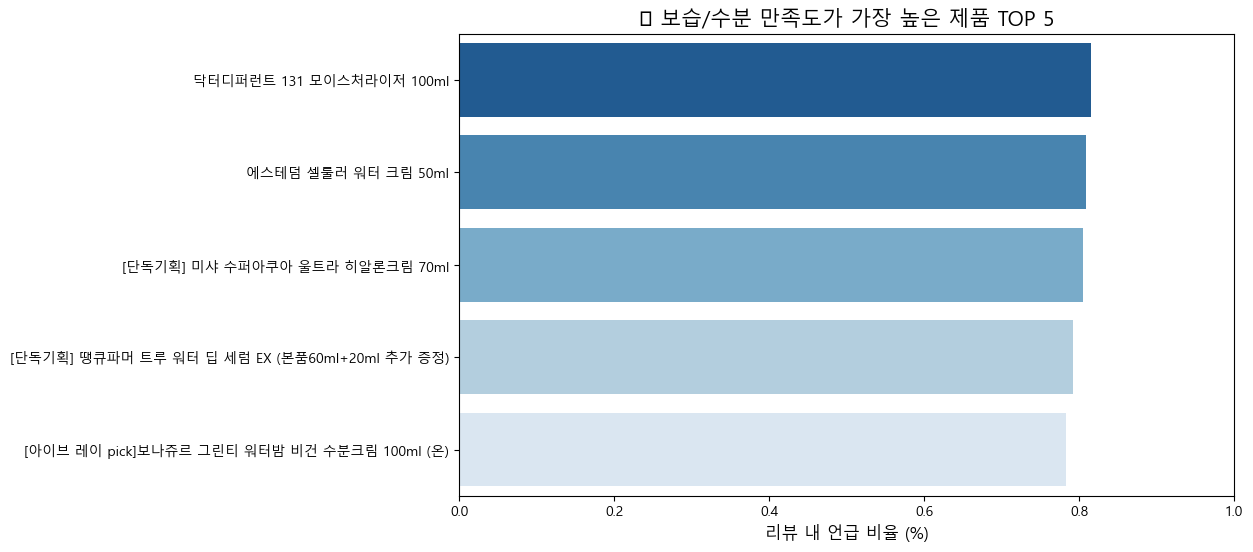

C:\Users\user\AppData\Local\Temp\ipykernel_1020\2582398694.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products[category_name], y=top_products.index, palette=color)
C:\Users\user\AppData\Local\Temp\ipykernel_1020\2582398694.py:50: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Malgun Gothic.
  plt.savefig(filename, bbox_inches='tight', dpi=300)


✅ 저장 완료: results/ranking_진정_트러블.png


C:\Users\user\PycharmProjects\Cosmetics_Project\.venv1\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


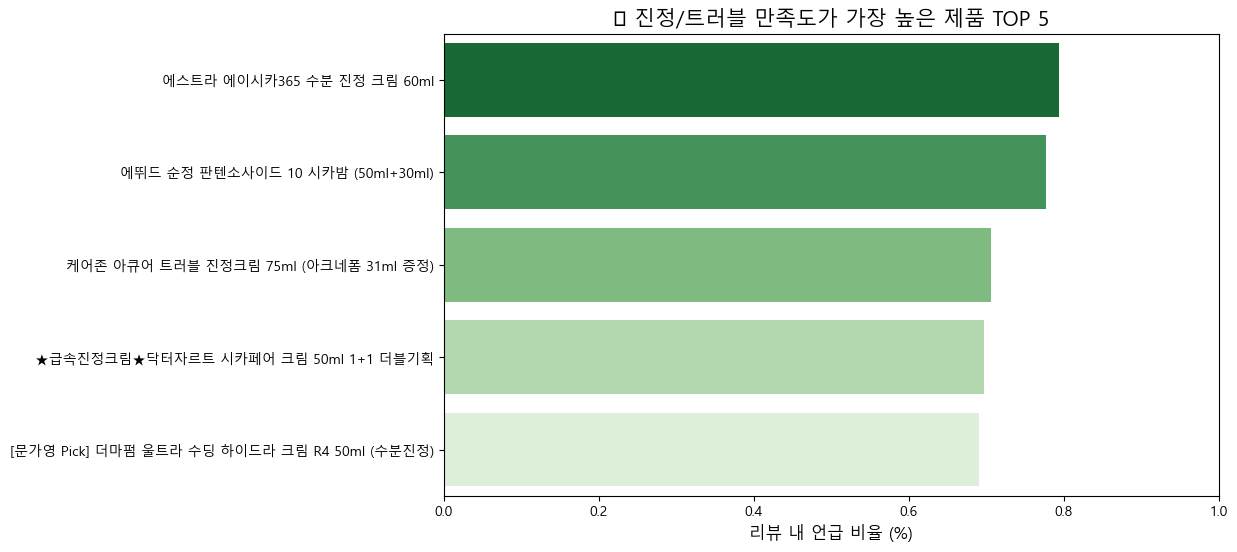

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc
import os

# 1. 한글 폰트 설정 (깨짐 방지)
def set_korean_font():
    system_name = platform.system()
    if system_name == 'Windows':
        font_path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=font_path).get_name()
        rc('font', family=font_name)
    elif system_name == 'Darwin': # Mac
        rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# 2. 데이터 로드 (방금 저장한 랭킹 파일)
RANKING_PATH = "data/03_final/product_ranking.csv"
# 만약 파일이 없으면 전체 결과에서 다시 계산
if not os.path.exists(RANKING_PATH):
    print("랭킹 파일이 없어서 'final_result.csv'에서 다시 계산합니다...")
    df = pd.read_csv("data/03_final/final_result.csv")
    product_stats = df.groupby(['product_name', 'category']).size().unstack(fill_value=0)
    product_stats = product_stats[product_stats.sum(axis=1) > 50] # 리뷰 50개 이상만
    product_ratios = product_stats.div(product_stats.sum(axis=1), axis=0)
else:
    product_ratios = pd.read_csv(RANKING_PATH, index_col=0)

# 3. 시각화 함수 정의
def plot_top_products(category_name, top_n=5, color='skyblue'):
    # 해당 카테고리 점수가 높은 순으로 정렬
    top_products = product_ratios.sort_values(by=category_name, ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    # 가로 막대 그래프 그리기
    sns.barplot(x=top_products[category_name], y=top_products.index, palette=color)

    plt.title(f"🏆 {category_name} 만족도가 가장 높은 제품 TOP {top_n}", fontsize=15)
    plt.xlabel('리뷰 내 언급 비율 (%)', fontsize=12)
    plt.ylabel('')
    plt.xlim(0, 1.0) # 비율은 0~1 사이

    # 이미지 저장
    filename = f"results/ranking_{category_name.replace('/', '_')}.png"
    os.makedirs("results", exist_ok=True)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"✅ 저장 완료: {filename}")
    plt.show()

# 4. 실행 (보습 & 진정 랭킹 그래프 생성)
plot_top_products('보습/수분', top_n=5, color='Blues_r')   # 파란색 테마
plot_top_products('진정/트러블', top_n=5, color='Greens_r') # 초록색 테마